## Demo facial keypointing in a video

#### Play the video with no facial keypoints

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time

In [2]:
# CONFIG STUFF here 
import torch

MODEL_PATH = r'models\best_models\best_resnet50_10.pth'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
VIDEO_PATH = 'videos/video_cap.mp4' # use 0 for webcam

In [3]:
print(DEVICE)

if DEVICE == 'cpu':
    model = torch.load(MODEL_PATH, map_location={'cuda:0': 'cpu'})
else:
    model = torch.load(MODEL_PATH)
    
model = model.to(DEVICE)
model.eval();

cuda


#### Let's set up some functions to make thing easier!

In [4]:
def get_model_outputs(image):
    with torch.no_grad():
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        image = image.transpose((2, 0, 1)) / 255.0
        image = torch.tensor(image, dtype=torch.float)
        image = image.unsqueeze(0).to(DEVICE)

        # get model output
        outputs = model(image)

    # prepare output keypoints
    outputs = outputs.cpu().detach().numpy().reshape(-1, 2)
    
    return outputs


def draw_keypoints(outputs, image):
    for i in range(outputs.shape[0]):
        x = int(outputs[i, 0])
        y = int(outputs[i, 1])
        cv2.circle(image, (x, y), 1, (0, 255, 0), -1, cv2.LINE_AA)


        # experiment with keypoint locations
        if i in [10000]:
            x = int(outputs[i, 0])
            y = int(outputs[i, 1])
            cv2.circle(image, (x, y), 1, (0, 0, 255), -1, cv2.LINE_AA)
                
                

In [33]:
# get webcam video or use path to saved video 
cap = cv2.VideoCapture(VIDEO_PATH)

# get FRAMES PER SECOND FOR VIDEO
FPS = cap.get(cv2.CAP_PROP_FPS)

if cap.isOpened()== False: 
    print("Error opening the video file!")
    
# get frame width and height
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

# get writer object to save video
# FPATH = 'videos/keypoints.mp4'
# writer = cv2.VideoWriter(FPATH, cv2.VideoWriter_fourcc(*'DIVX'),
#                          FPS, (frame_width, frame_height))


frame_count = 0
while cap.isOpened():
    
    ret, frame = cap.read()
    
    if ret == True:

        # update frame count
        frame_count += 1
        
        # get resized image copy for model
        image = frame.copy()
        image = cv2.resize(image, (224, 224))
        image_copy = image.copy() # save for later
 
        # pass video frame through model
        outputs = get_model_outputs(image)

        # draw facial keypoints on image_copy
        draw_keypoints(outputs, image_copy)

        # resize to original frame size for nice display
        image_frame = cv2.resize(image_copy, (frame_width, frame_height))

        # write to video
        # writer.write(image_frame)

        # write images for gif
        # cv2.imwrite(f'images/gif_images/keypoints/img_{frame_count:05d}.jpg', image_frame)
        
        # display frame
        cv2.imshow('frame', image_frame)

        # Press q to quit
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
 
    # automatically break if the video is over.
    else:
        break
        
cap.release()
cv2.destroyAllWindows()

In [21]:
cap.release()
cv2.destroyAllWindows()

### Save Frames as GIF

In [34]:
from PIL import Image
from glob import glob

def create_gif(save_path, frame_path):
    images = glob(f'{frame_path}/*.jpg')
    images.sort()

    frames = [Image.open(img) for img in images]

    frames_1 = frames[0]
    frames_1.save(save_path, format='GIF', append_images=frames,
                   save_all=True, duration=50, loop=0)

In [35]:
create_gif('images/keypoints.gif', 'images/gif_images/keypoints')

## Now make some image filters

#### Read in image filters 

In [5]:
orange = cv2.imread('images\orange_1.png', cv2.IMREAD_UNCHANGED)
googly_eye = cv2.imread('images\googly_eye.png', cv2.IMREAD_UNCHANGED)
teeth = cv2.imread('images/teeth_2.png', cv2.IMREAD_UNCHANGED)

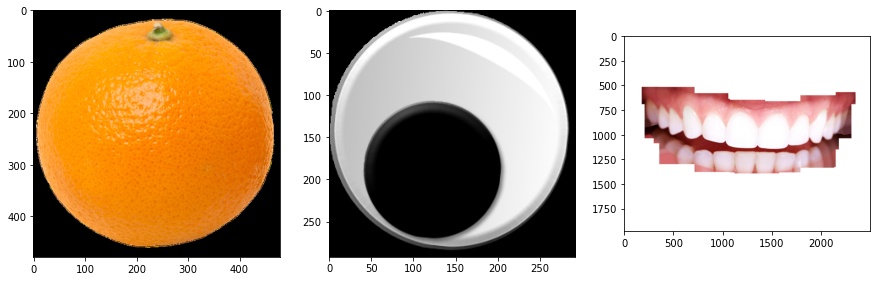

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(cv2.cvtColor(orange, cv2.COLOR_BGR2RGB));
ax[1].imshow(cv2.cvtColor(googly_eye, cv2.COLOR_BGR2RGB));
ax[2].imshow(cv2.cvtColor(teeth, cv2.COLOR_BGR2RGB));

In [48]:
# functions for filters (place in utls pyfile)
from math import floor, ceil


def get_orange_params(outputs):
    # set center to center of nose for now
    x = outputs[29, 0]
    y = outputs[29, 1]

    # set to width to distance between extreme edges of the face
    w = int(abs(outputs[16, 0] - outputs[0, 0]) * 1.25)
    
    # set height to distance from top of eyebrow to bottom of chin
    h = int(abs(outputs[19, 1] - outputs[8, 1]) * 2)
    
    return (x, y, w, h)


def get_mouth_params(outputs):
    # apply teeth filter to image
    x = outputs[67, 0]
    y = outputs[67, 1]

    # teeth width and height based on mouth
    w = int(abs(outputs[48, 0] - outputs[54, 0]) * 2.25)
    h = int(abs(outputs[57, 1] - outputs[51, 1]) * 2.75)
    
    return (x, y, w, h)


# we compute different widths and hieghts for extra googly effects
def get_right_eye_params(outputs, sz_scale):
    ''' sz_scale - scales the width and height of the eye'''
    # get center of right eye
    x = int(outputs[45,0] + outputs[42,0]) // 2
    y = int(outputs[47, 1] + outputs[43, 1]) // 2

    # get eye width
    w = int(abs(outputs[44,0] - outputs[27,0]) * sz_scale)

    # get eye height
    h = int(abs(outputs[24,1] - outputs[46,1]) * sz_scale)

    return (x, y, w, h)


def get_left_eye_params(outputs, sz_scale):
    ''' sz_scale - scales the width and height of the eye'''
    # get center of left eye
    x = int(outputs[39,0] + outputs[36,0]) // 2 
    y = int(outputs[40, 1] + outputs[38, 1]) // 2

    # get eye width
    w = int(abs(outputs[27,0] - outputs[37,0]) * sz_scale)

    # get eye height
    h = int(abs(outputs[19,1] - outputs[41,1]) * sz_scale)
    
    return (x, y, w, h)
        

def get_roi_from_center(pos_params, image):
    '''
        pos_params - tuple containing center x,y coords and width and height
        image - (arr) image of interest
        '''
    (x, y, w, h) = pos_params
    roi = image[floor(y-h/2):ceil(y+h/2),
                floor(x-w/2):ceil(x+w/2)] 
    
    return roi

def apply_filter(image, pos_params, roi):
    ''' image - (arr) image of interest
        pos_params - (tuple) contains center x,y coords and width and height
        roi (arr) - portion of original image with desired filter pixels replacing original image pixels
        '''
    (x, y, w, h) = pos_params
    image_copy = image.copy()
    image_copy[floor(y-h/2):ceil(y+h/2),
               floor(x-w/2):ceil(x+w/2)] = roi
    
    return image_copy

### Apply Googly eyes filter to video

In [30]:
# get webcam video or use path to saved video 
cap = cv2.VideoCapture(VIDEO_PATH)

# get FRAMES PER SECOND FOR VIDEO
FPS = cap.get(cv2.CAP_PROP_FPS)

if cap.isOpened()== False: 
    print("Error opening the video file!")
    
# get frame width and height
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

# get writer object to save video
# FPATH = 'videos/googly.mp4'
# writer = cv2.VideoWriter(FPATH, cv2.VideoWriter_fourcc(*'DIVX'),
#                          FPS, (frame_width, frame_height))

frame_count = 0
while cap.isOpened():
    
    ret, frame = cap.read()
    
    if ret == True:

        # update frame count
        frame_count += 1
        
        # get resized image copy for model
        image = frame.copy()
        image = cv2.resize(image, (224, 224))
        image_copy = image.copy() # save for later
 
        # pass video frame through model
        outputs = get_model_outputs(image)
        
        # ===================================================================
        # apply filters to image
        
        # get position params
        x_left, y_left, w_left, h_left = get_left_eye_params(outputs, 1.75)
        x_right, y_right, w_right, h_right = get_right_eye_params(outputs, 1.75)
    
        # get resized filters
        left_eye = cv2.resize(googly_eye, (w_left, h_left), interpolation=cv2.INTER_CUBIC)
        right_eye = cv2.resize(googly_eye, (w_right, h_right), interpolation=cv2.INTER_CUBIC)
        
        # get region of interest for filter
        roi_left = get_roi_from_center((x_left, y_left, w_left, h_left), image_copy)
        roi_right = get_roi_from_center((x_right, y_right, w_right, h_right), image_copy)
        
        # find all non-transparent pts
        left_idx = np.argwhere(left_eye[:,:,3] > 0)
        right_idx = np.argwhere(right_eye[:,:,3] > 0)

        # for each non-transparent point, replace the original image pixel with that of the desired filter
        for i in range(3): 
            roi_left[left_idx[:,0],left_idx[:,1],i] = left_eye[left_idx[:,0],left_idx[:,1],i] 
            roi_right[right_idx[:,0],right_idx[:,1],i] = right_eye[right_idx[:,0],right_idx[:,1],i]    

        # set the area of the image to the changed region(s) with desired filters
        image_copy = apply_filter(image_copy, (x_left, y_left, w_left, h_left), roi_left)
        image_copy = apply_filter(image_copy, (x_right, y_right, w_right, h_right), roi_right)

        # resize to original frame size for nice display
        image_frame = cv2.resize(image_copy, (frame_width, frame_height))
        
        # ===================================================================
        
        # write to video
        # writer.write(image_frame)

        # write images for gif
        # cv2.imwrite(f'images/gif_images/googly_eyes/img_{frame_count:05d}.jpg', image_frame)

        # display video
        cv2.imshow('frame', image_frame)

        # Press q to quit
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
 
    # automatically break if the video is over.
    else:
        break
        
cap.release()
cv2.destroyAllWindows()

In [31]:
# turn off camera and close windows in case of an error
cap.release()
cv2.destroyAllWindows()

In [32]:
# create gif
create_gif('images/googly_eyes.gif', 'images/gif_images/googly_eyes')

### Apply Googly Orange filter to video

In [49]:
# get webcam video or use path to saved video 
cap = cv2.VideoCapture(VIDEO_PATH)

# get FRAMES PER SECOND FOR VIDEO
FPS = cap.get(cv2.CAP_PROP_FPS)

if cap.isOpened()== False: 
    print("Error opening the video file!")
    
# get frame width and height
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

# get writer object to save video
# FPATH = 'videos/orange.mp4'
# writer = cv2.VideoWriter(FPATH, cv2.VideoWriter_fourcc(*'DIVX'),
#                          FPS, (frame_width, frame_height))

frame_count = 0
while cap.isOpened():
    
    ret, frame = cap.read()
    
    if ret == True:
        # update frame count
        frame_count += 1
        
        # get resized image copy for model
        image = frame.copy()
        image = cv2.resize(image, (224, 224))
        image_copy = image.copy() # save for later
 
        # pass video frame through model
        outputs = get_model_outputs(image)
        
        # ===================================================================
        # apply filters to image
        
        # get position params
        x_orng, y_orng, w_orng, h_orng = get_orange_params(outputs)
        
        x_mouf, y_mouf, w_mouf, h_mouf = get_mouth_params(outputs)
        
        x_left, y_left, w_left, h_left = get_left_eye_params(outputs, 1.75)
        x_right, y_right, w_right, h_right = get_right_eye_params(outputs,1.75)
    
        
        # get resized filters
        orng = cv2.resize(orange, (w_orng, h_orng), interpolation=cv2.INTER_CUBIC)
        mouf = cv2.resize(teeth, (w_mouf, h_mouf), interpolation=cv2.INTER_CUBIC)
        left_eye = cv2.resize(googly_eye, (w_left, h_left), interpolation=cv2.INTER_CUBIC)
        right_eye = cv2.resize(googly_eye, (w_right, h_right), interpolation=cv2.INTER_CUBIC)
        
        # get region of interest for filter
        roi_orng = get_roi_from_center((x_orng, y_orng, w_orng, h_orng), image_copy)
        roi_mouf = get_roi_from_center((x_mouf, y_mouf, w_mouf, h_mouf), image_copy)
        roi_left = get_roi_from_center((x_left, y_left, w_left, h_left), image_copy)
        roi_right = get_roi_from_center((x_right, y_right, w_right, h_right), image_copy)
        
        # find all non-transparent pts
        orng_idx = np.argwhere(orng[:,:,3] > 0)
        mouf_idx = np.argwhere(mouf[:,:,3] > 0)
        left_idx = np.argwhere(left_eye[:,:,3] > 0)
        right_idx = np.argwhere(right_eye[:,:,3] > 0)

        # for each non-transparent point, replace the original image pixel with that of the desired filter
        for i in range(3):
            roi_orng[orng_idx[:,0],orng_idx[:,1],i] = orng[orng_idx[:,0],orng_idx[:,1],i] 
            roi_mouf[mouf_idx[:,0],mouf_idx[:,1],i] = mouf[mouf_idx[:,0],mouf_idx[:,1],i] 
            roi_left[left_idx[:,0],left_idx[:,1],i] = left_eye[left_idx[:,0],left_idx[:,1],i] 
            roi_right[right_idx[:,0],right_idx[:,1],i] = right_eye[right_idx[:,0],right_idx[:,1],i]    

        # set the area of the image to the changed region(s) with desired filters
        image_copy = apply_filter(image_copy, (x_orng, y_orng, w_orng, h_orng), roi_orng)
        image_copy = apply_filter(image_copy, (x_mouf, y_mouf, w_mouf, h_mouf), roi_mouf)
        image_copy = apply_filter(image_copy, (x_left, y_left, w_left, h_left), roi_left)
        image_copy = apply_filter(image_copy, (x_right, y_right, w_right, h_right), roi_right)

        # ===================================================================
        
        # resize to original frame size for nice display
        image_frame = cv2.resize(image_copy, (frame_width, frame_height))
        
        # write to video
        # writer.write(image_frame)

        # write images for gif
        # cv2.imwrite(f'images/gif_images/orange/img_{frame_count:05d}.jpg', image_frame)

        # display video
        cv2.imshow('frame', image_frame)

        # Press q to quit
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
 
    # automatically break if the video is over.
    else:
        break
        
cap.release()
cv2.destroyAllWindows()

In [11]:
# turn off camera and close windows in case of an error
cap.release()
cv2.destroyAllWindows()

In [50]:
# create gif
create_gif('images/orange.gif', 'images/gif_images/orange')